#### Here I am doing some exercise 
#### creating a trading agent using DQN model 
I start by creating:
1. trading environment
2. DQN model class
3. helping functions for running the train test and data manipulation
4. creating synthetic data for a stock (can replace with real data from finanial APIs)
5. training the agent
6. testing and comparing to Hold strategy

In [10]:
!pip install gym yfinance

In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
import gym
from gym import spaces
import matplotlib.pyplot as plt
import yfinance as yf
import types  # For method replacement

## Trading Environment

In [19]:
# Custom trading environment
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000, transaction_fee_percent=0.001):
        super(StockTradingEnv, self).__init__()
        
        # Data for the environment
        self.df = df
        self.initial_balance = initial_balance
        self.transaction_fee_percent = transaction_fee_percent
        
        # Environment dimensions
        self.n_features = 7  # OHLCV + technical indicators
        
        # Action space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)
        
        # Observation space: market data + position info
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.n_features + 2,), dtype=np.float32
        )
        
        # Episode management
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.net_worth = initial_balance
        
    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0
        self.net_worth = self.initial_balance
        self.current_step = 0
        if len(self.df) <= 0:
            raise ValueError("DataFrame is empty!")
        return self._get_observation()
    
    def step(self, action):
        # Take action
        self._take_action(action)
        
        # Update current step
        self.current_step += 1
        
        # Calculate reward
        reward = self.net_worth - self.initial_balance
        
        # Check if done
        done = self.current_step >= len(self.df) - 1
        
        # Get observation
        obs = self._get_observation()
        
        # Info
        info = {
            'balance': self.balance,
            'shares_held': self.shares_held,
            'net_worth': self.net_worth
        }
        
        return obs, reward, done, info
    
    def _get_observation(self):
        
        if self.current_step >= len(self.df):
            print(f"Warning: current_step ({self.current_step}) is out of bounds for DataFrame of length {len(self.df)}")
            return np.zeros(self.n_features + 2)
        
        # Get market data
        frame = self.df.iloc[self.current_step]
        
        # Feature normalization (simple method, can be improved)
        normalized_data = [
            frame['Open'] / 1000,
            frame['High'] / 1000,
            frame['Low'] / 1000,
            frame['Close'] / 1000,
            frame['Volume'] / 1e9,
            frame['SMA_20'] / 1000 if 'SMA_20' in frame else 0,
            frame['RSI'] / 100 if 'RSI' in frame else 0
        ]
        
        # Add position info (cash balance and shares held)
        position = [
            self.balance / self.initial_balance,
            self.shares_held / 100  # Normalized approximately
        ]
        
        return np.array(normalized_data + position)
    
    def _take_action(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        
        # Buy
        if action == 1:
            # Calculate maximum shares we can buy
            max_possible_shares = self.balance / (current_price * (1 + self.transaction_fee_percent))
            # Buy 10% of max possible
            shares_to_buy = max_possible_shares * 0.1
            shares_to_buy = int(shares_to_buy)
            
            if shares_to_buy > 0:
                # Calculate cost with transaction fee
                cost = shares_to_buy * current_price * (1 + self.transaction_fee_percent)
                
                # Check if we have enough balance
                if self.balance >= cost:
                    self.balance -= cost
                    self.shares_held += shares_to_buy
        
        # Sell
        elif action == 2:
            if self.shares_held > 0:
                # Sell 10% of held shares
                shares_to_sell = int(self.shares_held * 0.1)
                
                if shares_to_sell > 0:
                    # Calculate sale value with transaction fee
                    sales_value = shares_to_sell * current_price * (1 - self.transaction_fee_percent)
                    self.balance += sales_value
                    self.shares_held -= shares_to_sell
                    self.total_shares_sold += shares_to_sell
                    self.total_sales_value += sales_value
        
        # Update net worth
        self.net_worth = self.balance + self.shares_held * current_price

## DQN Agent

In [20]:
# Deep Q-Network Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.95    # Discount factor
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.batch_size = 32
        
    def _build_model(self):
        # Neural Net for Deep-Q learning
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state, training=True):
        if training and np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        act_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
            
        if len(self.memory) < batch_size:
            return
        
        minibatch = np.random.choice(self.memory, batch_size, replace=False)
        
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])
        
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        
        targets = self.model.predict(states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)
        
        for i in range(len(minibatch)):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                targets[i][actions[i]] = rewards[i] + self.gamma * np.amax(target_next[i])
        
        self.model.fit(states, targets, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def load(self, name):
        self.model.load_weights(name)
        
    def save(self, name):
        self.model.save_weights(name)

# Modified replay method for the DQNAgent class
def modified_replay(self, batch_size=None):
    if batch_size is None:
        batch_size = self.batch_size
        
    if len(self.memory) < batch_size:
        return
    
    # Safely sample from memory
    try:
        minibatch = np.random.choice(len(self.memory), batch_size, replace=False)
        minibatch = [self.memory[i] for i in minibatch]
    except Exception as e:
        print(f"Error sampling from memory: {e}")
        return
    
    # Extract and prepare states more carefully
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    
    for memory in minibatch:
        # Check if memory has the expected structure
        if len(memory) != 5:
            print(f"Memory tuple has wrong length: {len(memory)}. Expected 5.")
            continue
            
        state, action, reward, next_state, done = memory
        
        # Ensure states are properly shaped
        if not isinstance(state, np.ndarray):
            state = np.array(state)
        if not isinstance(next_state, np.ndarray):
            next_state = np.array(next_state)
            
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)
    
    states = np.array(states)
    next_states = np.array(next_states)
    
    # Make predictions and update targets
    targets = self.model.predict(states, verbose=0)
    target_next = self.model.predict(next_states, verbose=0)
    
    for i in range(len(minibatch)):
        if dones[i]:
            targets[i][actions[i]] = rewards[i]
        else:
            targets[i][actions[i]] = rewards[i] + self.gamma * np.amax(target_next[i])
    
    # Train the model
    self.model.fit(states, targets, epochs=1, verbose=0)
    
    # Update epsilon
    if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay

# Replace the agent's replay method with our modified version
agent.replay = types.MethodType(modified_replay, agent)

## Data manipluation functions

In [24]:
# Function to add technical indicators
def add_technical_indicators(df):
    # Simple Moving Average
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    
    # Relative Strength Index
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Fill NaN values
    df.fillna(method='bfill', inplace=True)
    
    return df



# Main training function
# Modified training function to handle arrays correctly
def train_agent(env, agent, episodes=20):
    scores = []
    
    for e in range(episodes):
        state = env.reset()
        # Make sure state is 1D before reshaping
        if hasattr(state, 'shape') and len(state.shape) > 1:
            state = state.flatten()
        state = np.reshape(state, [1, env.observation_space.shape[0]])
        done = False
        score = 0
        
        while not done:
            action = agent.act(state[0])
            next_state, reward, done, info = env.step(action)
            reward = reward if not done else -10
            
            # Make sure next_state is 1D before reshaping
            if hasattr(next_state, 'shape') and len(next_state.shape) > 1:
                next_state = next_state.flatten()
            next_state = np.reshape(next_state, [1, env.observation_space.shape[0]])
            
            agent.remember(state[0], action, reward, next_state[0], done)
            state = next_state
            score += reward
            
            if done:
                print(f"Episode: {e+1}/{episodes}, Score: {score}, Epsilon: {agent.epsilon:.2f}")
                scores.append(score)
                break
        
        # Modified replay logic with better error handling
        if len(agent.memory) > agent.batch_size:
            try:
                agent.replay()
            except Exception as e:
                print(f"Error during replay: {e}")
                # Print shapes to debug
                sample_memory = agent.memory[0]
                print(f"Sample memory state shape: {sample_memory[0].shape if hasattr(sample_memory[0], 'shape') else 'Not an array'}")
                print(f"Sample memory next_state shape: {sample_memory[3].shape if hasattr(sample_memory[3], 'shape') else 'Not an array'}")
                break
            
    return scores





# Test the trained agent
def test_agent(env, agent):
    state = env.reset()
    state = np.reshape(state, [1, env.observation_space.shape[0]])
    done = False
    balance_history = [env.balance]
    net_worth_history = [env.net_worth]
    
    while not done:
        action = agent.act(state[0], training=False)
        next_state, reward, done, info = env.step(action)
        state = np.reshape(next_state, [1, env.observation_space.shape[0]])
        
        balance_history.append(info['balance'])
        net_worth_history.append(info['net_worth'])
        
    return balance_history, net_worth_history

## Synthetic data creation

In [16]:
# Create realistic synthetic stock data (fixed version)
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Function to generate synthetic stock data
def generate_stock_data(start_date, end_date, initial_price=100, volatility=0.01, upward_drift=0.0003):
    # Create date range (only business days)
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')
    
    # Number of days
    n_days = len(date_range)
    
    # Generate daily returns with a slight upward drift
    np.random.seed(42)  # For reproducibility
    daily_returns = np.random.normal(upward_drift, volatility, n_days)
    
    # Calculate price series
    price_series = initial_price * (1 + daily_returns).cumprod()
    
    # Create DataFrame
    df = pd.DataFrame(index=date_range)
    
    # Close prices
    df['Close'] = price_series
    
    # Create realistic Open, High, Low values
    df['Open'] = df['Close'].shift(1)
    df.loc[df.index[0], 'Open'] = initial_price  # Set first day's open
    
    # Handle any NaN values in Open before calculating volatility
    df['Open'] = df['Open'].fillna(initial_price)
    
    # Daily volatility for High and Low
    daily_volatility = volatility * df['Open'] * 2
    
    # High is max of (Open, Close) plus some random volatility
    df['High'] = np.maximum(df['Open'], df['Close']) + np.random.uniform(0, 1, n_days) * daily_volatility
    
    # Low is min of (Open, Close) minus some random volatility
    df['Low'] = np.minimum(df['Open'], df['Close']) - np.random.uniform(0, 1, n_days) * daily_volatility
    
    # Volume with some randomness and price correlation but without NaN values
    base_volume = 1000000
    df['price_change'] = df['Close'].pct_change().fillna(0)
    volume_factor = 1 + 5 * np.abs(df['price_change']) + 0.5 * np.random.random(n_days)
    df['Volume'] = (base_volume * volume_factor).round().astype('int64')
    df.drop('price_change', axis=1, inplace=True)
    
    # Add technical indicators
    # Simple Moving Average (20-day)
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    
    # Relative Strength Index (14-day)
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    
    # Avoid division by zero
    avg_loss = avg_loss.replace(0, 0.001)
    
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Fill all remaining NaN values
    df = df.bfill().ffill()
    
    return df

# Generate training and testing datasets
try:
    train_data = generate_stock_data('2018-01-01', '2020-12-31')
    # Continue from the last price in training data for realistic continuity
    last_price = train_data['Close'].iloc[-1]
    test_data = generate_stock_data('2021-01-01', '2021-12-31', initial_price=last_price)

    # Print information about the generated data
    print("Training data shape:", train_data.shape)
    print("Training data sample:")
    print(train_data.head())
    print("\nTest data shape:", test_data.shape)
    print("Test data sample:")
    print(test_data.head())

    # Check for NaN values
    print("\nTraining data NaN count:")
    print(train_data.isna().sum())
    print("\nTest data NaN count:")
    print(test_data.isna().sum())
    
except Exception as e:
    print(f"Error generating data: {e}")
    
    # Simplified fallback approach if the first method fails
    print("\nTrying simplified approach...")
    
    # Simple synthetic data generation
    train_dates = pd.date_range(start='2018-01-01', end='2020-12-31', freq='B')
    test_dates = pd.date_range(start='2021-01-01', end='2021-12-31', freq='B')
    
    # Create basic dataframes
    train_data = pd.DataFrame(index=train_dates)
    test_data = pd.DataFrame(index=test_dates)
    
    # Generate price data using a simple random walk
    np.random.seed(42)
    train_returns = np.random.normal(0.0005, 0.01, len(train_dates))
    train_data['Close'] = 100 * (1 + train_returns).cumprod()
    
    # Test data continues from where training data left off
    test_returns = np.random.normal(0.0005, 0.01, len(test_dates))
    starting_price = train_data['Close'].iloc[-1]
    test_data['Close'] = starting_price * (1 + test_returns).cumprod()
    
    # Add other columns
    for df in [train_data, test_data]:
        df['Open'] = df['Close'] * np.random.uniform(0.99, 1.01, len(df))
        df['High'] = df[['Open', 'Close']].max(axis=1) * np.random.uniform(1.0, 1.02, len(df))
        df['Low'] = df[['Open', 'Close']].min(axis=1) * np.random.uniform(0.98, 1.0, len(df))
        df['Volume'] = np.random.randint(100000, 1000000, len(df))
        df['SMA_20'] = df['Close'].rolling(window=20).mean().fillna(method='bfill')
        df['RSI'] = 50 + np.random.uniform(-20, 20, len(df))  # Simplified RSI
        
    print("Generated simple training data with shape:", train_data.shape)
    print("Generated simple test data with shape:", test_data.shape)

Training data shape: (784, 7)
Training data sample:
                 Close        Open        High         Low   Volume  \
2018-01-01  100.526714  100.000000  102.139836   99.866696  1160748   
2018-01-02  100.417880  100.526714  101.851221   99.375603  1243632   
2018-01-03  101.098400  100.417880  102.488739  100.116287  1146899   
2018-01-04  102.668488  101.098400  104.385535   99.607333  1397890   
2018-01-05  102.458887  102.668488  103.181149  101.407106  1499698   

                SMA_20        RSI  
2018-01-01  101.827835  59.213161  
2018-01-02  101.827835  59.213161  
2018-01-03  101.827835  59.213161  
2018-01-04  101.827835  59.213161  
2018-01-05  101.827835  59.213161  

Test data shape: (261, 7)
Test data sample:
                 Close        Open        High         Low   Volume  \
2021-01-01  113.209561  112.616395  114.316841  111.988918  1262195   
2021-01-04  113.086996  113.209561  114.281592  112.686210  1225795   
2021-01-05  113.853373  113.086996  114.245111 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


## Training the agent

In [26]:
# Create training environment for DQN Agent
env = StockTradingEnv(train_data)

# Create agent
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

# Train agent
scores = train_agent(env, agent, episodes=20)

# Save model
agent.save("dqn_trader.weights.h5")

Episode: 1/20, Score: 298109.38483976317, Epsilon: 1.00
Error during replay: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (783, 5) + inhomogeneous part.
Sample memory state shape: (9,)
Sample memory next_state shape: (9,)


# Testing Results

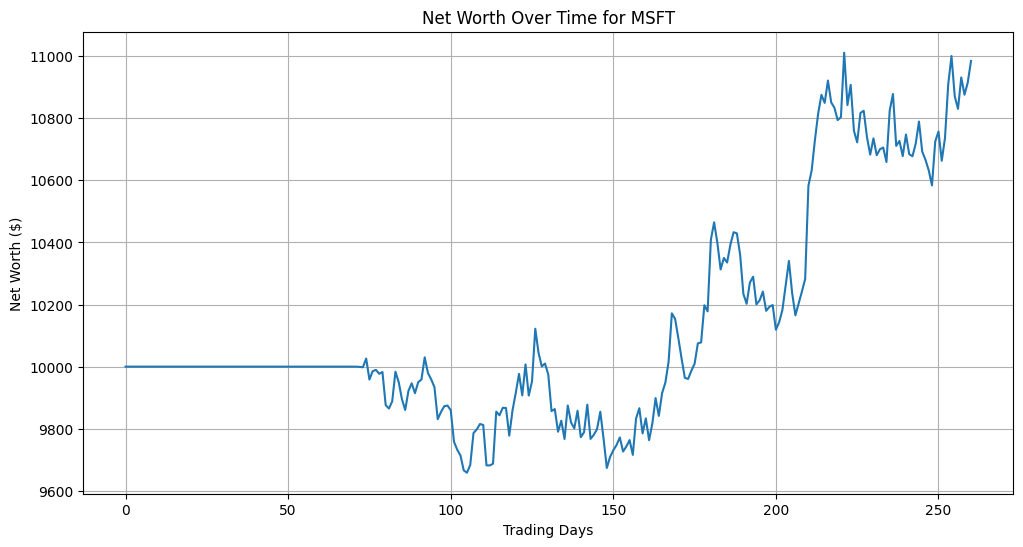


Trading Results for MSFT
Initial Investment: $10000.00
Final Net Worth: $10984.49
Return on Investment: 9.84%

Buy and Hold Strategy
Initial Investment: $10000.00
Final Value: $10738.58
Return on Investment: 7.39%


In [27]:
# Test on unseen data
test_env = StockTradingEnv(test_data)
balance_history, net_worth_history = test_agent(test_env, agent)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(net_worth_history)
plt.title(f'Net Worth Over Time for {ticker}')
plt.xlabel('Trading Days')
plt.ylabel('Net Worth ($)')
plt.grid(True)
plt.show()

# Calculate performance metrics
initial_investment = test_env.initial_balance
final_net_worth = net_worth_history[-1]
roi = (final_net_worth - initial_investment) / initial_investment * 100

print(f"\nTrading Results for {ticker}")
print(f"Initial Investment: ${initial_investment:.2f}")
print(f"Final Net Worth: ${final_net_worth:.2f}")
print(f"Return on Investment: {roi:.2f}%")

# Compare to buy and hold strategy
first_price = test_data.iloc[0]['Close']
last_price = test_data.iloc[-1]['Close']
shares_buy_hold = initial_investment / first_price
buy_hold_value = shares_buy_hold * last_price
buy_hold_roi = (buy_hold_value - initial_investment) / initial_investment * 100

print(f"\nBuy and Hold Strategy")
print(f"Initial Investment: ${initial_investment:.2f}")
print(f"Final Value: ${buy_hold_value:.2f}")
print(f"Return on Investment: {buy_hold_roi:.2f}%")